# Comparison of equations of state for model fluids

In this notebook, we take a look at three model fluid equations of state and compare them.
These EoS are:

- The PeTS equation of state (from `feos.pets`),
- the uv-theory equation of state (from `feos.uvtheory`), 
- the uv-B3-theory equation of state (from `feos.uvtheory` using `VirialOrder.Third`), and
- the Thol equation of state (implemented in as Python class).

The PeTS equation of state is for a Lennard-Jones fluid with cut off distance of $r_c = 2.5 \sigma$ and a potential shift while the uv-theory and Thol equation of state model the full Lennard-Jones potential. Note that the uv-theory was developed to model Mie potentials and not primarily adjusted to the Lennard-Jones fluid. Thus, we don't expect similar results when comparing uv-theory and Thol to PeTS.

In [46]:
import numpy as np
from feos.si import *
from feos.uvtheory import UVParameters, Perturbation, VirialOrder
from feos.pets import PetsParameters
from feos.eos import State, PhaseEquilibrium, PhaseDiagram, EquationOfState, Contributions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
#sns.set_palette('asd')
sns.set_palette("hls", 8)
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 8)

## Implement the Thol equation of state as Python class

In [5]:
# Parameters for Thol EoS:
A = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,
              2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])
N = np.array([0.005208073, 2.186252000, -2.161016000, 1.452700000, -2.041792000, 0.186952860, -0.090988445, 
              -0.497456100, 0.109014310, -0.800559220, -0.568839000, -0.620862500, -1.466717700, 1.891469000, 
              -0.138370100, -0.386964500, 0.126570200, 0.605781000, 1.179189000, -0.477326790, -9.921857500, -0.574793200, 0.003772923])
T = np.array([1.000, 0.320, 0.505, 0.672, 0.843, 0.898, 1.294, 2.590, 1.786, 2.770, 1.786,
              1.205, 2.830, 2.548, 4.650, 1.385, 1.460, 1.351, 0.660, 1.496, 1.830, 1.616, 4.970])
D = np.array([4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 2.0, 2.0, 3.0, 1.0,
              1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0])
L = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0,
              1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
ETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.067, 1.522,
                8.82, 1.722, 0.679, 1.883, 3.925, 2.461, 28.2, 0.753, 0.82])
BETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.625,
                 0.638, 3.91, 0.156, 0.157, 0.153, 1.16, 1.73, 383, 0.112, 0.119])
GAMMA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.71,
                  0.86, 1.94, 1.48, 1.49, 1.945, 3.02, 1.11, 1.17, 1.33, 0.24])
EPSILON = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2053,
                    0.409, 0.6, 1.203, 1.829, 1.397, 1.39, 0.539, 0.934, 2.369, 2.43])

class Thol:
    def __init__(self):
        self.sigma = 3.7039 * ANGSTROM
        self.eps_k = 150.03 * KELVIN
        self.tc = 1.32 * self.eps_k / KELVIN
        self.rhoc = 0.31 / self.sigma**3 * ANGSTROM**3
        
    def components(self): 
        return 1
    
    def subset(self, components):
        return self
        
    def molar_weight(self):
        return np.array([1.0])
    
    def max_density(self, moles):
        return 0.04
    
    def helmholtz_energy(self, state):
        """
        state (StateHD):
            temperature in Kelvin als Float, Dual oder HD oder HD3, HDD, HDD3,
            partial_density in # / Angstrom^3
            volume in Angstrom^3
            moles in mol
        """
        tau = self.tc / state.temperature
        delta = np.sum(state.partial_density) / self.rhoc
        a = 0.0
        
        for i in range(6):
            a = a + N[i] * delta**D[i] * tau**T[i]
        for i in range(6, 12):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(-1.0 * delta**L[i])
        for i in range(12, 23):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(- 1.0 * ETA[i] * (delta - EPSILON[i])**2.0 - 1.0 * BETA[i] * (tau - 1.0 * GAMMA[i])**2.0)
        return a * np.sum(state.moles)

## Instantiate all equations of state

In [6]:
sigma = 3.7039
sigma_a = sigma * ANGSTROM
eps_k = 150.03
eps_k_k = eps_k * KELVIN

parameters = UVParameters.new_simple(12.0, 6.0, sigma, eps_k)
uvtheory_wca = EquationOfState.uvtheory(parameters)
uvtheory_bh = EquationOfState.uvtheory(parameters, perturbation=Perturbation.BarkerHenderson)
uvtheory_b3 = EquationOfState.uvtheory(parameters, virial_order=VirialOrder.Third)

parameters = PetsParameters.from_values(sigma, eps_k)
pets = EquationOfState.pets(parameters)

thol = EquationOfState.python(Thol())
s3 = State(thol, temperature=300*KELVIN, pressure=1*BAR)

## Compare Helmholtz energies at single state point

In [16]:
s1 = State(uvtheory_wca, temperature=300*KELVIN, pressure=1*BAR)
s2 = State(uvtheory_b3, temperature=300*KELVIN, pressure=1*BAR)
s3 = State(thol, temperature=300*KELVIN, pressure=1*BAR)
s4 = State(pets, temperature=300*KELVIN, pressure=1*BAR)

In [17]:
s1.molar_helmholtz_energy(Contributions.ResidualNvt) / (RGAS * 300 * KELVIN)

-0.0016213224956115704

In [18]:
s2.molar_helmholtz_energy(Contributions.ResidualNvt) / (RGAS * 300 * KELVIN)

-0.0016138652202999679

In [19]:
s3.molar_helmholtz_energy(Contributions.ResidualNvt) / (RGAS * 300 * KELVIN)

-0.0016144150962601586

In [20]:
s4.molar_helmholtz_energy(Contributions.ResidualNvt) / (RGAS * 300 * KELVIN)

-0.000940704010881386

## Compare critical temperatures

In [23]:
(
    #State.critical_point(thol).temperature / eps_k_k, 
    State.critical_point(uvtheory_wca).temperature / eps_k_k, 
    State.critical_point(uvtheory_bh).temperature / eps_k_k,
    State.critical_point(uvtheory_b3).temperature / eps_k_k
)

(1.3097658041494296, 1.3208296613277397, 1.3132940626554175)

## Phase diagrams

In [32]:
%%time
vle_uv = PhaseDiagram.pure(uvtheory_wca, 150*KELVIN, 500)

CPU times: user 52.1 ms, sys: 0 ns, total: 52.1 ms
Wall time: 50.9 ms


In [33]:
%%time
vle_uv_bh = PhaseDiagram.pure(uvtheory_bh, 150*KELVIN, 500)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 33.9 ms


In [34]:
%%time
vle_uv_b3 = PhaseDiagram.pure(uvtheory_b3, 150*KELVIN, 500)

CPU times: user 51.9 ms, sys: 0 ns, total: 51.9 ms
Wall time: 50.8 ms


In [35]:
%%time
vle_thol = PhaseDiagram.pure(thol, 150*KELVIN, 500)

thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: PyErr { type: <class 'AttributeError'>, value: AttributeError("'builtins.StateHDDV2' object has no attribute 'temperature'"), traceback: Some(<traceback object at 0x7f7f8cc73b80>) }', feos-core/src/python/user_defined.rs:210:1


PanicException: called `Result::unwrap()` on an `Err` value: PyErr { type: <class 'AttributeError'>, value: AttributeError("'builtins.StateHDDV2' object has no attribute 'temperature'"), traceback: Some(<traceback object at 0x7f7f8cc73b80>) }

In [36]:
%%time
vle_pets = PhaseDiagram.pure(pets, 150*KELVIN, 500)

CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 20.1 ms


### Compare phase diagrams

In [71]:
nist_data = pd.read_csv("data/lennard_jones_nist.csv", delim_whitespace=True)
nist_data = nist_data[::5]
nist_data.head()

,t,rhov,rhol,p
0,0.700,0.002012,0.843237,0.001381
5,0.705,0.002145,0.841186,0.001481
10,0.710,0.002284,0.839106,0.001586
15,0.715,0.002431,0.836999,0.001698
20,0.720,0.002584,0.834868,0.001815


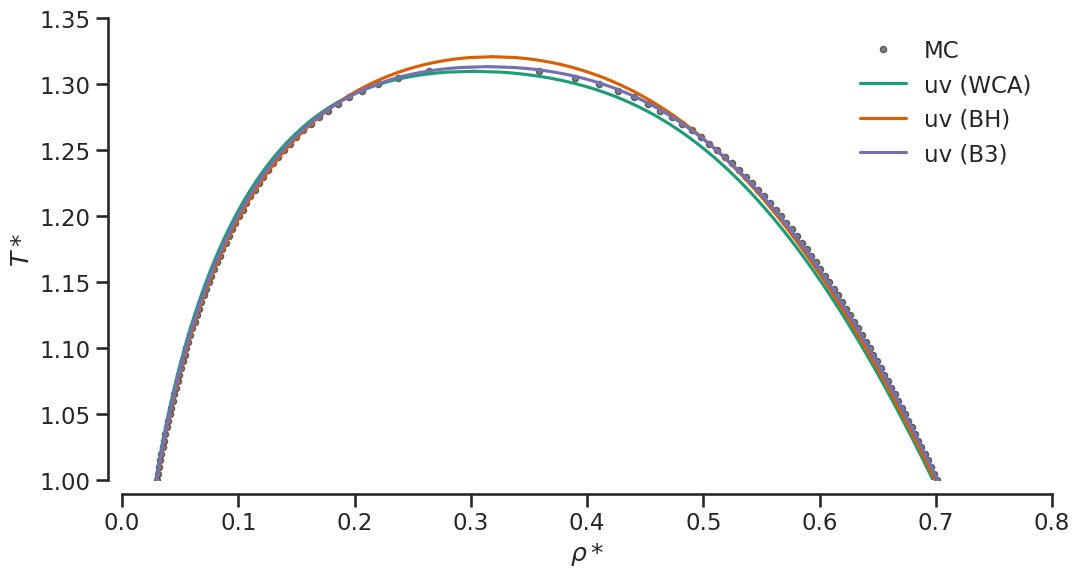

In [76]:
s3 = NAV * sigma_a**3
colors = sns.color_palette("Dark2", n_colors = 6)
plt.figure(figsize=(12, 6))

plt.plot(nist_data.rhov, nist_data.t, linestyle="", color="k", marker=".", label='MC', alpha=0.5)
plt.plot(nist_data.rhol, nist_data.t, linestyle="", color="k", marker=".", alpha=0.5)

plt.plot(vle_uv.vapor.density * s3 , vle_uv.vapor.temperature / eps_k_k, color=colors[0], label='uv (WCA)')
plt.plot(vle_uv.liquid.density * s3, vle_uv.vapor.temperature / eps_k_k, color=colors[0])

plt.plot(vle_uv_bh.vapor.density * s3 , vle_uv_bh.vapor.temperature / eps_k_k, color=colors[1], label='uv (BH)')
plt.plot(vle_uv_bh.liquid.density * s3, vle_uv_bh.vapor.temperature / eps_k_k, color=colors[1])

plt.plot(vle_uv_b3.vapor.density * s3 , vle_uv_b3.vapor.temperature / eps_k_k, color=colors[2], label='uv (B3)')
plt.plot(vle_uv_b3.liquid.density * s3, vle_uv_b3.vapor.temperature / eps_k_k, color=colors[2])

plt.ylabel(r"$T*$")
plt.xlabel(r"$\rho*$")
plt.xlim(0., 0.8)
plt.ylim(1.0, 1.35)
plt.legend(frameon=False)
sns.despine(offset=10);